In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# VAE model

In [29]:
import numpy as np
import matplotlib.pyplot as plt

import keras.utils
from keras.layers import Input, Dense, Lambda, concatenate, add, subtract
from keras.models import Model, Sequential
from keras import backend as K
from keras import objectives
from keras.datasets import mnist
from keras.activations import softmax
from keras.objectives import binary_crossentropy as bce

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x (InputLayer)               (None, 2500)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               1280512   
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_15 (Dense)             (None, 100)               25700     
_________________________________________________________________
z (Lambda)                   (None, 100)               0         
Total params: 1,437,540
Trainable params: 1,437,540
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Out

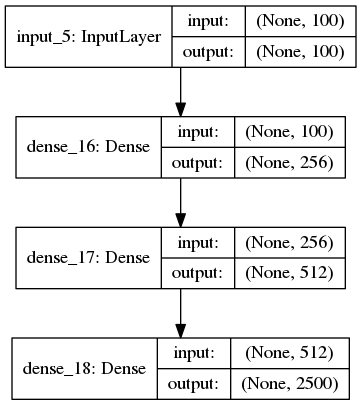

In [7]:
batch_size = 100
#data_dim = 784
data_dim = 2500
M = 10
N = 10
nb_epoch = 200
epsilon_std = 0.01

anneal_rate = 0.0003
min_temperature = 0.5

tau = K.variable(5.0, name="temperature")
#x = Input(batch_shape=(batch_size, data_dim))
x = Input(shape = (data_dim, ), name="x")
h = Dense(256, activation='relu')(Dense(512, activation='relu')(x))
logits_y = Dense(M*N)(h)


def sampling(logits_y):
    U = K.random_uniform(K.shape(logits_y), 0, 1)
    y = logits_y - K.log(-K.log(U + 1e-20) + 1e-20) # logits + gumbel noise
    y = softmax(K.reshape(y, (-1, N, M)) / tau)
    y = K.reshape(y, (-1, N*M))
    return y

z = Lambda(sampling, output_shape=(M*N,), name ="z")(logits_y)
encoder = Model(x, z, name= "encoder")

decoder_input = Input(shape= (M*N, ))
x_hat = Dense(256, activation='relu', input_shape=(N*M, )) (decoder_input)
x_hat = Dense(512, activation='relu') (x_hat)
x_hat = Dense(data_dim, activation='sigmoid') (x_hat)
"""
decoder = Sequential(name = "decoder")
decoder.add(Dense(256, activation='relu', input_shape=(N*M, )))
decoder.add(Dense(512, activation='relu'))
#generator.add(Dense(1024, activation='relu'))
decoder.add(Dense(data_dim, activation='sigmoid'))
x_hat = decoder(z)
"""
decoder = Model(decoder_input, x_hat, name = "decoder")

# x_hat = Dense(data_dim, activation='softmax')(Dense(512, activation='relu')(Dense(256, activation='relu')(z)))
def gumbel_loss(x, x_hat):
    q_y = K.reshape(logits_y, (-1, N, M))
    q_y = softmax(q_y)
    log_q_y = K.log(q_y + 1e-20)
    kl_tmp = q_y * (log_q_y - K.log(1.0/M))
    KL = K.sum(kl_tmp, axis=(1, 2))
    elbo = data_dim * bce(x, x_hat) - KL 
    return elbo

vaeInput = x
vaeOutput = decoder ( encoder(x) )


vae = Model(vaeInput, vaeOutput, name="GumbelVae")
vae.compile(optimizer='adam', loss=gumbel_loss)

encoder.summary()
decoder.summary()
vae.summary()
keras.utils.plot_model(encoder, "GumbelEncoder.png", show_shapes = True)
keras.utils.plot_model(decoder, "GumbelDecoder.png", show_shapes = True)

# transition model

Model: "transition_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  (None, 2500)         0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 100)          1437540     x[0][0]                          
                                                                 x[0][0]                          
                                                                 x_prime[0][0]                    
__________________________________________________________________________________________________
action (InputLayer)             (None, 17)           0                                            
___________________________________________________________________________________

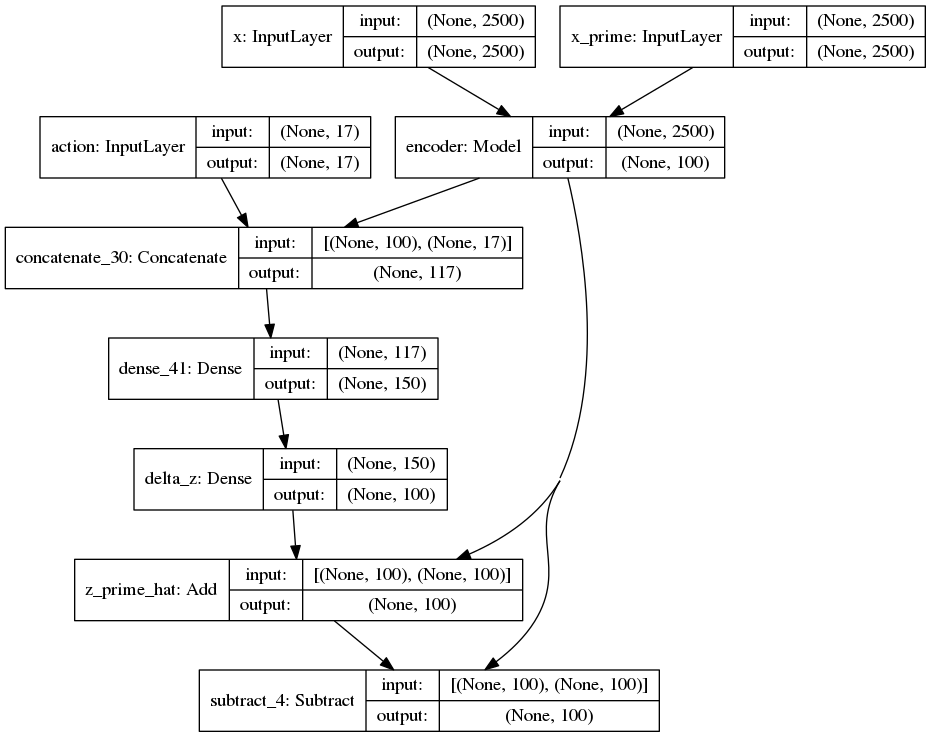

In [33]:
# x = image current state
# x_prime = image next state

# z = abstract current state
# z_prime = asbtract next state

# delta_z = variation predicted by the transition function
# z_prime_hat = abstract next state as predicted by the transition function (z + delta_z)

#z_prime_hat - z_prime must be equal to 0 => train with output [0,0,0,0, ... ,0]

num_actions = 17

action = Input(shape =(num_actions, ), name = "action")
x_prime = Input(shape = (data_dim, ), name = "x_prime")

tr_input = concatenate([encoder(x), action])
delta_z = Dense(150, activation = "tanh") (tr_input)
delta_z = Dense(M*N, activation = "sigmoid", name="delta_z") (delta_z)
#tr_output è la predizione del nuovo stato astratto
z_prime_hat = add([encoder(x), delta_z], name ="z_prime_hat")


z_prime = encoder(x_prime)
final_output = subtract([z_prime_hat, z_prime])


transition_model = Model([x, action, x_prime], final_output, name = "transition_model")

transition_model.compile(optimizer='adam', loss='mse')

transition_model.summary()
keras.utils.plot_model(transition_model, "transition_model.png", show_shapes = True)

# load dataset

In [52]:
import loadDataset as loadDS

# train the VAE on MNIST digits
'''
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
'''

#MontezumaDataset
x_train, _ , y_train, _  = loadDS.loadMontezumaDataset(channels=1, samplesB = 1915)
x_test, _ , y_test , _ = loadDS.loadMontezumaDataset(filename = "datasets/datasetLabeled.txt", channels=1)

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

#x_test = x_test[:100]
#y_test = y_test[:100]

print(x_train.shape)
print(x_test.shape)

print(y_train.shape)
print(y_test.shape)

############ samplesA = 0
############ samplesB = 1915
...LOADED DATASET...
X.shape (1915, 50, 50, 1)
y.shape (1915,)
...SPLITTED DATASET...
test_size =  0
X_train.shape  (1915, 50, 50, 1)
y_train.shape  (1915,)
X_test.shape  (0,)
y_test.shape  (0,)
############ samplesA = 0
############ samplesB = 0
...LOADED DATASET...
X.shape (193, 50, 50, 1)
y.shape (193,)
...SPLITTED DATASET...
test_size =  0
X_train.shape  (193, 50, 50, 1)
y_train.shape  (193,)
X_test.shape  (0,)
y_test.shape  (0,)
(1915, 2500)
(193, 2500)
(1915,)
(193,)


In [53]:

for e in range(nb_epoch):
    vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=1,
        batch_size=batch_size,
        validation_data=(x_test, x_test))
    K.set_value(tau, np.max([K.get_value(tau) * np.exp(- anneal_rate * e), min_temperature]))

/home/elena/environments/PYTHON3/lib/python3.5/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1915 samples, validate on 193 samples
Epoch 1/1
1915/1915 [==============================] - 2s 838us/step - loss: 1276.7517 - val_loss: 863.4584
Train on 1915 samples, validate on 193 samples
Epoch 1/1
 400/1915 [=====>........................] - ETA: 0s - loss: 902.2604

/home/elena/environments/PYTHON3/lib/python3.5/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


1915/1915 [==============================] - 1s 499us/step - loss: 925.1755 - val_loss: 850.8325
Train on 1915 samples, validate on 193 samples
Epoch 1/1
1915/1915 [==============================] - 1s 492us/step - loss: 888.7421 - val_loss: 811.6886
Train on 1915 samples, validate on 193 samples
Epoch 1/1
1915/1915 [==============================] - 1s 506us/step - loss: 873.1706 - val_loss: 808.4543
Train on 1915 samples, validate on 193 samples
Epoch 1/1
1915/1915 [==============================] - 1s 546us/step - loss: 869.8558 - val_loss: 806.1423
Train on 1915 samples, validate on 193 samples
Epoch 1/1
1915/1915 [==============================] - 1s 489us/step - loss: 862.6295 - val_loss: 799.1540
Train on 1915 samples, validate on 193 samples
Epoch 1/1
1915/1915 [==============================] - 1s 605us/step - loss: 855.8275 - val_loss: 787.3380
Train on 1915 samples, validate on 193 samples
Epoch 1/1
1915/1915 [==============================] - 1s 514us/step - loss: 838.6019 

1915/1915 [==============================] - 1s 484us/step - loss: 505.6461 - val_loss: 470.7922
Train on 1915 samples, validate on 193 samples
Epoch 1/1
1915/1915 [==============================] - 1s 478us/step - loss: 503.5532 - val_loss: 467.7601
Train on 1915 samples, validate on 193 samples
Epoch 1/1
1915/1915 [==============================] - 1s 483us/step - loss: 502.3226 - val_loss: 466.4669
Train on 1915 samples, validate on 193 samples
Epoch 1/1
1915/1915 [==============================] - 1s 481us/step - loss: 503.0016 - val_loss: 468.1164
Train on 1915 samples, validate on 193 samples
Epoch 1/1
1915/1915 [==============================] - 1s 482us/step - loss: 503.9092 - val_loss: 468.3900
Train on 1915 samples, validate on 193 samples
Epoch 1/1
1915/1915 [==============================] - 1s 470us/step - loss: 516.0959 - val_loss: 472.2105
Train on 1915 samples, validate on 193 samples
Epoch 1/1
1915/1915 [==============================] - 1s 473us/step - loss: 509.7431 

# Sala il modello encoder

In [54]:
encoder.save("GumbelEncoder")
decoder.save("GumbelDecoder")
vae.save("GumbelVae")

# Visualize results

In [55]:
argmax_y = K.max(K.reshape(logits_y, (-1, N, M)), axis=-1, keepdims=True)
argmax_y = K.equal(K.reshape(logits_y, (-1, N, M)), argmax_y)
encoderfunc = K.function([x], [argmax_y, x_hat])

(<matplotlib.image.AxesImage at 0x7fd17953b080>, (-0.5, 49.5, 49.5, -0.5))

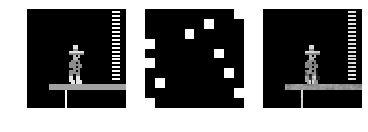

In [56]:
code, x_hat_test = encoderfunc([x_test[:100]])
subplot(131)
imshow(x_test[:1].reshape(50, 50), cmap='gray'), axis('off')
subplot(132)
imshow(code[:1].reshape(N, M), cmap='gray'), axis('off')
subplot(133)
imshow(x_hat_test[:1].reshape(50, 50), cmap='gray'), axis('off')

In [57]:
#CODES extraction
C = np.zeros((100, N*M))
for i in range(0, 100, 100):
    c, _ = encoderfunc([x_test[i:i+100]])
    C[i:i+100] = c.reshape(100, -1)
    

In [58]:
#T-SNE of codes
from sklearn.manifold.t_sne import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, metric='hamming')
X = tsne.fit_transform(C)

In [106]:
#HISTOGRAMS of one one-hot distribution
def oneHot2number(onehot):
    for i in range(len(onehot)):
        if onehot[i] == 1:
          return i

#visualizzazione one hot features
Cred = C[:,:M]
print(C.shape)

steps = np.zeros((M,1))
print("steps", steps)
print(steps.shape)
X = np.zeros((100, 2))
for i in range(100):
    print(Cred[i])
    n = oneHot2number(Cred[i])
    print(n)
    X[i,0] = n
    #print("n-esimo step", steps[n, 0])
    X[i,1] = steps[n,0]
    #X[i,1] = 0
    print(C[i])
    print(mode(C[i]))


    steps[n,0]+= 0.1
    
print("steps", steps)  


(100, 100)
steps [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
(10, 1)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
9
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0.]
0
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
1
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1.]
1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
9
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0

In [116]:
#HISTOGRAMS of mode
def mode(n_onehot):
    global N, M
    score = [0 for i in range(M)]

    for i in range(N):
        onehot = n_onehot[i*M:(i+1)*M]
        #print(onehot)
        numb = oneHot2number(onehot)
        #print(numb)
        score[numb]+= 1
    return score.index(max(score))

#visualizzazione one hot features

steps = np.zeros((M,1))
print("steps", steps)
print(steps.shape)
X = np.zeros((100, 2))
for i in range(100):
    print(C[i])
    n = mode(C[i])
    print(n)
    X[i,0] = n
    #print("n-esimo step", steps[n, 0])
    X[i,1] = steps[n,0]

    steps[n,0]+= 0.1
    
print("steps", steps) 

steps [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
(10, 1)
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0.]
2
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0.]
8
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1.]
3
[

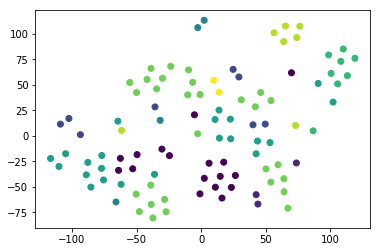

In [59]:
#VISUALIZATION

plt.scatter(X[:, 0], X[:, 1], c=y_test[:100]) 
plt.show()